<a href="https://colab.research.google.com/github/hughesymendes/TIC-27491137/blob/Dip4_model/dip4_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightkurve

!pip install exoplanet

!pip install pymc3==3.8

!pip install corner

     |████████████████████████████████| 501kB 2.8MB/s 
     |████████████████████████████████| 25.2MB 169kB/s 
     |████████████████████████████████| 235kB 44.2MB/s 
     |████████████████████████████████| 4.5MB 42.7MB/s 
     |████████████████████████████████| 2.7MB 45.2MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-cp36-none-any.whl size=11376 sha256=d9b8eb1bc76f6d0922b1228f50e6ea4465b9c1bbbf9be77148931f053c11cd05
  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3e7805c30f60dc
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96457 sha256=4d44822040b49b819b508d2cf9e14c15d592d8fe856a3213b63ce0e43f35dc61
  Stored in directory: /root/.cache/pip/wheels/d9/d3/0e/5b0b743a8abd50373705427438456da5dc2621891138d7a618
  Created wheel for astroquery: filename=astroquery-0.4-cp36-none-any.whl size=3582510 sha256=c26883da6e36b07d37d910b571a4cd4b1a368fe9f20942a63aa19ed7890520a0
  Stored in directory: /root/.cache/

In [0]:


import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#downloading data from MAST
tpf = search_targetpixelfile("TIC 27491137").download()
aper = tpf.create_threshold_mask()
tpf.plot(aperture_mask = aper, mask_color = "red")

#Creating Lightcurve from TPF
lc = tpf.to_lightcurve()

#Masking out Argabrightening events
mask = np.isfinite(lc.flux_err)
clipped = lc[mask]

clipped.plot()

flc = clipped.flatten(window_length = 1001).plot()

pixels = tpf.flux[mask][:, ~aper]
dm1 = lk.DesignMatrix(pixels, name='pixels').pca(3).append_constant()

# We'll do a 3D low order polynomial in TIME, COLUMN CENTROID and ROW CENTROID:

r, c = tpf[mask].estimate_centroids()
r, c = r - np.median(r), c - np.median(c)


t = (lc[mask].cadenceno - np.median(lc.cadenceno))/(len(lc.time))


dm2 = lk.DesignMatrix(np.vstack([r, c, r*c, r**2, c**2, r**2*c, c**2*r, r**2*c**2,
                                t*r, t*c, t*r*c, t*r**2, t*c**2, t*r**2*c, t*c**2*r, t*r**2*c**2]).T, name='centroids')

spline = lk.designmatrix.create_spline_matrix(lc[mask].time, n_knots=35)

dm = lk.DesignMatrixCollection([dm1, dm2, spline])

# Make a very hacky cadence mask:
b = lc[mask].flatten(1001).bin(10)
_, m = b.remove_outliers(3, return_mask=True)
cadence_mask = np.interp(lc[mask].time, b.time, m) != 0

#Tried to make a mask by adding all the areas that i wanted to mask, however it errored out saying needed to be 2D?
#mask = (clipped[3300:3900], clipped[7100:7350], clipped[9500:10000], clipped[15700:]) = True

r = lk.RegressionCorrector(lc[mask])
r.correct(dm, sigma=3., cadence_mask=~cadence_mask)

r.diagnose()

# Remove INSTRUMENT systematics
corr = (r.diagnostic_lightcurves['pixels'] + r.diagnostic_lightcurves['centroids']).flux
corr -= np.median(corr)
clc = (lc[mask] - corr)

fig, ax = plt.subplots(figsize=(50, 4))
(clc).errorbar(ls='-', ax=ax)

# Divide through by STELLAR flux
stellar_flux = r.diagnostic_lightcurves['spline'].flux + np.median(clc.flux)

fig, ax = plt.subplots(figsize=(50, 7))
(clc/stellar_flux).errorbar(ls='-', ax=ax)

In [0]:
clean_lc = (clc/stellar_flux)
clean_lc.plot()

dip = clean_lc[15650:]
dip.plot()

dx = np.append( np.array( [], dtype="float64" ),dip.time )
dy = np.append( np.array( [], dtype="float64" ), dip.flux - 1.0075 )
dy_err = np.append( np.array( [], dtype="float64" ), dip.flux_err )

In [0]:
plt.plot(dx, dy, color="C0", lw=1)

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


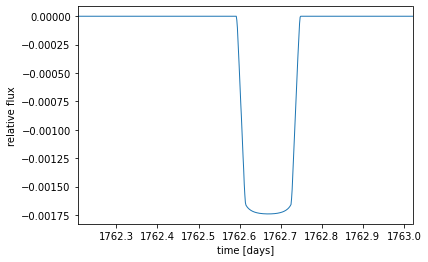

In [0]:
import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=10, t0 =1762.67, r_star = 0.78, m_star = 0.87)

# Compute a limb-darkened light curve using starry
t = np.linspace(1762.20580502,1763.02108133, 588)
#found values from a paper for Kepler and TESS that gives a=0.4984, b= 0.1939 (using quadratic law).
# 'u' seems to be linear but is only given as one value whereas 'u' here is 2D so I've input values 
# In between the two closest stellar temps. paper-- https://arxiv.org/pdf/0912.2274.pdf

u = [0.05, 0.1]
light_curve = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.032, t=t, texp=0.02)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=1)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [b, r, u, logp, t0, mean]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 3374.713483070566 -> 3499.3725543169803


IndexError: ignored

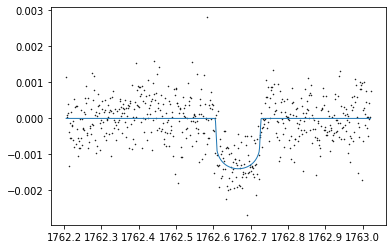

In [0]:
import pymc3 as pm

r_star = 0.78


with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0, sd=1.0)

    # The time of a reference transit for each planet
    #Mu seems to be centre of transit.
    #For random.uniform "Samples are uniformly distributed over the half-open interval [low, high) (includes low, but excludes high)"
    t0 = pm.Normal("t0", mu=1762.67, sd=1.0, shape=1)

    # The log period; also tracking the period itself
    logP = pm.Uniform("logp", lower=0, upper=3, testval=1)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.195, 0.385]))

    #r is in units of R_star which is units of R_sun
    r = pm.Uniform("r", lower=0.01, upper=0.04, shape=1)
    b = xo.distributions.ImpactParameter("b", ror=r/r_star, shape=1)

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # In this line, we simulate the dataset that we will fit
    y = dy
    
    # The likelihood function assuming known Gaussian uncertainty- 
    #Likelihood function is a function that represents the distribution from an actual test sample
    pm.Normal("obs", mu=light_curve, sd=dy_err, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated dataset
    # Posterior distribution is usually given as Prior*Likelihood
    map_soln = xo.optimize(start=model.test_point)


plt.plot(t, y, ".k", ms=1, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(1)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

In [0]:
#random.seed will create a random first instance of data where there is no prior data
#Because we're using MCMC methods to now sample from our data i believe that it creates
#an initial value for the sample to then be drawn ontop of from our model. 
#42 is like the ID for this seed, ie whenever 42 is passed the same result for the seed is achieved (reproducability)

np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (4 chains in 1 job)
NUTS: [b, r, u, logp, t0, mean]
Sampling chain 3, 0 divergences: 100%|██████████| 6000/6000 [02:41<00:00, 37.22it/s]
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
The number of effective samples is smaller than 25% for some paramete

In [0]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

/usr/local/lib/python3.6/dist-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
period,8.633,4.038,4.036,17.369,0.093,0.069,1886.0,1704.0,2382.0,1985.0,1.0
t0[0],1762.665,0.002,1762.662,1762.668,0.000,0.000,6095.0,6084.0,6099.0,7544.0,1.0
r[0],0.034,0.002,0.031,0.038,0.000,0.000,2077.0,2017.0,2236.0,2232.0,1.0
b[0],0.426,0.233,0.041,0.785,0.005,0.004,2415.0,2110.0,2084.0,2710.0,1.0
u[0],0.625,0.348,0.000,1.184,0.004,0.003,6607.0,6607.0,6208.0,4801.0,1.0
u[1],0.136,0.378,-0.522,0.812,0.005,0.004,6572.0,5588.0,6399.0,6404.0,1.0
mean,0.000,0.000,-0.000,0.000,0.000,0.000,7498.0,6770.0,7497.0,6134.0,1.0


In [0]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["period", "r", "b", "t0"])
truth = np.concatenate(xo.eval_in_model([period, r, b, t0], model.test_point, model=model))
corner.corner(
    samples, truths=truth, labels=["Period", "Radius", "b", "t_0"]
);

ValueError: ignored